# Prioritised screening assignments
This notebook is used to create assignments in the **OECD instruments** project on NACSOS-nexus   
Project ID: `8d36c360-3775-4d43-8f30-9fcd6151fe30`

Requirements:
```
pip install -U "nacsos_data[utils,scripts] @ git+ssh://git@gitlab.pik-potsdam.de/mcc-apsis/nacsos/nacsos-data.git@v0.16.0"
pip install -U pandas, torch, evaluate, tqdm, datasets, transformers, matplotlib
```

First, this notebook should be copied and the counter in the filename increased by 1. The notebook is kept in the repository as a log for each assignment scope.

You need to make changes in four places:
* Adjust the assignment scopes and resolutions where labels come from
* Adjust the filename where predictions are saved directly after training/predicting
* Adjust the filename where predictions were saved before running assignments
* Adjust the name, description, and configuration for the new assignment scope
* Adjust the filename where predictions and assignments are saved at the end

In [2]:
import logging
import uuid

import pandas as pd
import numpy as np
from sqlalchemy import select, func, distinct, or_, and_, union, text

from nacsos_data.db import get_engine
from nacsos_data.db.schemas.imports import Import, m2m_import_item_table
from nacsos_data.db.schemas.items.academic import AcademicItem, AcademicItemVariant
from nacsos_data.db.schemas.items.base import Item
from nacsos_data.db.schemas import AnnotationScheme, AssignmentScope, Assignment, Annotation, BotAnnotationMetaData, BotAnnotation
from nacsos_data.util.academic.duplicate import str_to_title_slug

db_engine = get_engine(conf_file='/usr/share/nacsos/server.env')

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('import')
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = None

PROJECT_ID = '8d36c360-3775-4d43-8f30-9fcd6151fe30'
SCHEME_ID = 'b6239498-aca3-4a5c-a8c0-879068378cb8'

IMPORT_ALL = '3833189f-28d4-441e-8276-53ddd399a8ed'
IMPORT_REL = '9a0c57a2-326c-4309-a8aa-58630071c79b'
IMPORTS = {
    IMPORT_ALL: 'Import (all)',
    IMPORT_REL: 'Classified relevant'
}

USERS = {
    'diana.danilenko': '37b6ce42-6008-4d5a-a307-797098a8f7d2',
    'tarun.khanna': '2f5f9cf5-7970-4576-9330-aee4d98030f0',
    'sarah.hoang': '46f155d0-4354-4b78-a096-53d6bc1e81f4',
    'klaas.miersch': 'ca4ad15d-cd34-4f06-9c86-c7422979011e',
    'andres.mena': '34536463-6250-43f4-8318-2595c273fa7e',
    'max.callaghan': 'b4c20ee5-e415-4ac8-8e9d-77770311e38c'
}
USERS_MAP = {v: k for k, v in USERS.items()}

## Data helpers
Some of the cells later on require you to specify the imports, annotation scheme, assignment scopes, or resolutions to use as labelled data. The following three cells are helpers to generate these lists.

In [3]:
with db_engine.session() as session:
    rslt = session.execute(select(AssignmentScope).join(AnnotationScheme).where(AnnotationScheme.project_id == PROJECT_ID).order_by(AssignmentScope.name)).scalars().all()
    for r in rslt:
        print(f"'{r.assignment_scope_id}', -- {r.name}")

'aa5694d1-af1f-4e16-8800-e952aaf9775b', -- 12082024_prioritised_independent
'7e9b2d50-8ae6-47b2-89bb-74f02c819e3e', -- 12082024_prioritised_independent
'44aae15f-3967-4e60-9533-72d02af1f04a', -- 19082024_prioritised_independent
'2d78dea8-6d0a-4f28-b2dc-136bff3416a1', -- Random sample 1
'7f4e9c0b-0aa4-4db9-8d22-a7bfbb82a896', -- Random sample 2
'117d4e99-90fa-4c8e-99c8-761ad356057c', -- Random sample 3
'f5b9a0f7-77ff-48dc-ab2b-659aca30ba14', -- randomsample_relimport


In [4]:
with db_engine.session() as session:
    rslt = session.execute(select(BotAnnotationMetaData).where(BotAnnotationMetaData.project_id == PROJECT_ID).order_by(BotAnnotationMetaData.name)).scalars().all()
    for r in rslt:
        print(f"'{r.bot_annotation_metadata_id}', -- {r.name}")

'91b2a57d-2713-4cc8-9339-f8bb5b88a1f3', -- Klaas-Sarah
'354fd78f-14be-4042-b744-ee2b31c1f4b4', -- Sarah
'e0660ab5-8d47-4dd3-a28a-7c8fb487f72b', -- Tarun-Sarah


In [5]:
with db_engine.session() as session:
    rslt = session.execute(select(Import).where(Import.project_id == PROJECT_ID).order_by(Import.name)).scalars().all()
    for r in rslt:
        print(f"'{r.import_id}': '{r.name}',")

'3833189f-28d4-441e-8276-53ddd399a8ed': 'All climate policy documents',
'cfd4ceef-21ef-425d-80ca-d620c131c3e4': 'Predicted Relevant Documents',
'9a0c57a2-326c-4309-a8aa-58630071c79b': 'Predicted Relevant Documents copy',


## Data preparation
The following cells fetch all the data from the database.

You may need to adjust the list of assignment scopes (in `ass.assignment_scope_id::text = ANY (array [...])`) for all labels that were not resolved yet (using "majority vote" of double-codings). Also, you may need to adjust the list of resolved labels (in `a.bot_annotation_metadata_id::text = ANY (array [...])`).    
Scopes that were resolved should not appear in the list of `assignment_scope_id`s, but only in the list of `bot_annotation_metadata_id`s!

This query usually takes ~20-60s to finish.

In [6]:
stmt = text('''
WITH labels_flat as (SELECT i.item_id, json_build_object('key', ba.key, 'value', ba.multi_int, 'incl', ba.value_bool) as label
                     FROM item i
                              JOIN bot_annotation ba ON ba.item_id = i.item_id
                     WHERE i.project_id = :project_id
                       AND ba.key = ANY (array ['inclusion', 'sector'])
                       AND ba.bot_annotation_metadata_id::text = ANY (array [
                        '91b2a57d-2713-4cc8-9339-f8bb5b88a1f3', -- Klaas-Sarah
                        '354fd78f-14be-4042-b744-ee2b31c1f4b4', -- Sarah
                        'e0660ab5-8d47-4dd3-a28a-7c8fb487f72b' -- Tarun-Sarah
                         ])),
     labels as (SELECT item_id, json_agg(label) as labels
                FROM labels_flat
                GROUP BY item_id),
     ulabels_flat as (SELECT i.item_id, json_build_object('user', a.user_id, 'key', a.key, 'value', a.multi_int, 'incl', a.value_bool) as label
                      FROM item i
                               JOIN annotation a ON a.item_id = i.item_id
                               JOIN assignment ass ON a.assignment_id = ass.assignment_id
                      WHERE i.project_id = :project_id
                        AND a.key = ANY (array ['inclusion', 'sector'])
                        AND ass.assignment_scope_id::text = ANY (array [
                        'aa5694d1-af1f-4e16-8800-e952aaf9775b', -- 12082024_prioritised_independent
                        '7e9b2d50-8ae6-47b2-89bb-74f02c819e3e', -- 12082024_prioritised_independent
                        '44aae15f-3967-4e60-9533-72d02af1f04a', -- 19082024_prioritised_independent
                        '2d78dea8-6d0a-4f28-b2dc-136bff3416a1', -- Random sample 1
                        '7f4e9c0b-0aa4-4db9-8d22-a7bfbb82a896', -- Random sample 2
                        '117d4e99-90fa-4c8e-99c8-761ad356057c', -- Random sample 3
                        'f5b9a0f7-77ff-48dc-ab2b-659aca30ba14' -- randomsample_relimport
                          ])),
     ulabels as (SELECT item_id, json_agg(label) as labels
                FROM ulabels_flat
                GROUP BY item_id),
     imports as (SELECT item_id, array_agg(DISTINCT import_id) as imports
                 FROM m2m_import_item mii
                 GROUP BY item_id)
SELECT i.item_id,
       i.text              as abstract,
       ai.title,
       ai.publication_year as py,
       ai.wos_id,
       ai.doi,
       labels.labels,
       ulabels.labels as user_labels,
       imports.imports
FROM item i
         JOIN academic_item ai on i.item_id = ai.item_id
         LEFT OUTER JOIN labels ON i.item_id = labels.item_id
         LEFT OUTER JOIN ulabels ON i.item_id = ulabels.item_id
         LEFT OUTER JOIN imports ON i.item_id = imports.item_id
WHERE i.project_id = :project_id;
''')

with db_engine.session() as session:
    rslt = session.execute(stmt, {'project_id': PROJECT_ID}).mappings().all()
    
    assigned_item_ids = session.execute(
                        select(distinct(Assignment.item_id))
                           .join(Item)
                           .where(Item.project_id == PROJECT_ID)).scalars().all()
    assigned_item_ids = [str(r) for r in assigned_item_ids]

We'd like to transform the data we retrieved from the database a little more and construct a dataframe in the following cell.

In [19]:
SECTORS = [{'name': 'AFOLU', 'hint': '', 'value': 1, 'children': None}, {'name': 'Buildings', 'hint': None, 'value': 2, 'children': None}, {'name': 'Industry', 'hint': None, 'value': 3, 'children': None}, {'name': 'Energy', 'hint': None, 'value': 4, 'children': None}, {'name': 'Transport', 'hint': None, 'value': 5, 'children': None}, {'name': 'Waste', 'hint': None, 'value': 6, 'children': None}, {'name': 'Cross-sectoral', 'hint': None, 'value': 15, 'children': None}]

data = [{
        'item_id': str(r['item_id']),
        'title': r['title'],
        'abstract': r['abstract'],
        'text': f"{r['title']} {r['abstract']}",
        'wos_id': r['wos_id'],
        'doi': r['doi'],
        'py': r['py'],
        'labels': r['labels'],
        'user_labels': r['user_labels'],
        'imports': [str(ri) for ri in r['imports']],
        **{
            IMPORTS[str(im)]: True
            for im in r['imports']
            if str(im) in IMPORTS
        },
    # Resolved labels
        **{
            'res|inclusion': li['incl']
            for li in (r['labels'] or [])
            if li['key'] == 'inclusion'
        },
        **{
            f'res|sector|{v}': True
            for li in (r['labels'] or [])
            for v in (li['value'] or [])
            if li['key'] == 'sector'
        },
    # Unresolved labels
        **{
            'inclusion': li['incl']
            for li in (r['user_labels'] or [])
            if li['key'] == 'inclusion' and li['incl'] is not None
        },
        **{
            f'sector|{v}': True
            for li in (r['user_labels'] or [])
            for v in (li['value'] or [])
            if li['key'] == 'sector'
        },
        **{
            f'{USERS_MAP[str(li["user"])]}|inclusion': li['incl']
            for li in (r['user_labels'] or [])
            if li['key'] == 'inclusion'
        },
        **{
            f'{USERS_MAP[str(li["user"])]}|sector|{v}': True
            for li in (r['user_labels'] or [])
            for v in (li['value'] or [])
            if li['key'] == 'sector'
        },
    } for r in rslt]

df = pd.DataFrame(data)    
df['incl'] = df['inclusion'].astype('Int8')
df['py'] = df['py'].astype('Int16')
df.loc[df['item_id'].isin(assigned_item_ids), 'assigned'] = True
df.loc[df['inclusion'].notnull(), 'seen'] = True
df.loc[df['res|inclusion'].notnull(), 'resolved'] = True
df = df.replace({np.nan: None})

def oring(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret |= a
    return ret

def anding(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret &= a
    return ret

mask_seen = (~df['labels'].isna() | ~df['user_labels'].isna())
mask_unseen = ~mask_seen

keys_user_incl = [f'{name}|inclusion' for name in USERS.keys()]
keys_user_sect = [f'{name}|sector|{sec["value"]}' for name in USERS.keys() for sec in SECTORS]
keys_sect = [f'sector|{sec["value"]}' for sec in SECTORS]

print(df.columns)

print('Shape:', df.shape)
print(f'Seen: {mask_seen.sum():,} | unseen: {mask_unseen.sum():,}')
df.head()

Index(['item_id', 'title', 'abstract', 'text', 'wos_id', 'doi', 'py', 'labels',
       'user_labels', 'imports', 'Import (all)', 'Classified relevant',
       'inclusion', 'sector|1', 'sarah.hoang|inclusion',
       'sarah.hoang|sector|1', 'res|inclusion', 'res|sector|4', 'sector|4',
       'sarah.hoang|sector|4', 'sector|3', 'sarah.hoang|sector|3',
       'res|sector|15', 'sector|15', 'tarun.khanna|inclusion',
       'tarun.khanna|sector|15', 'sarah.hoang|sector|15', 'res|sector|2',
       'sector|2', 'sarah.hoang|sector|2', 'sector|5', 'sarah.hoang|sector|5',
       'res|sector|1', 'res|sector|5', 'res|sector|3', 'tarun.khanna|sector|3',
       'klaas.miersch|inclusion', 'res|sector|6', 'sector|6',
       'sarah.hoang|sector|6', 'tarun.khanna|sector|5',
       'tarun.khanna|sector|1', 'tarun.khanna|sector|6',
       'tarun.khanna|sector|4', 'res|sector|7', 'res|sector|8', 'res|sector|9',
       'sector|7', 'sector|9', 'sector|8', 'klaas.miersch|sector|7',
       'klaas.miersch|sector

item_id  \
0  0000a68e-dc09-40ee-97f2-17b88310fde6   
1  0000e39d-9aeb-4642-8022-06991a52299e   
2  00010d32-1f9a-4a05-9531-594dc7c4da30   
3  0001d1ce-51b1-4ee2-8879-6a289739d69b   
4  00035ac4-f4f5-468b-b758-6d328a0db924   

                                               title  \
0  Proposing a smart electricity pricing model fo...   
1  Egypt's nationally determined contributions to...   
2  Biofuel Development in Nigeria Production and ...   
3        How Are Banks Doing on Sustainable Finance?   
4  Creating greener pastures: Environmental gentr...   

                                            abstract  \
0  The idea of smart grid is currently receiving ...   
1  During Paris Agreement, a historic climate lan...   
2  Exploring renewable energy resources stimulate...   
3  In recent years, the banking sector has starte...   
4  In recent decades both city planners and citiz...   

                                                text wos_id  \
0  Proposing a smart electricity pricing model fo...   None   
1  Egypt's nationally determined contributions to...   None   
2  Biofuel Development in Nigeria Production and ...   None   
3  How Are Banks Doing on Sustainable Finance? In...   None   
4  Creating greener pastures: Environmental gentr...   None   

                            doi    py labels user_labels  \
0    10.1109/aupec.2014.6966479  2014   None        None   
1     10.21608/ijisd.2020.73503  2020   None        None   
2  10.9734/jenrr/2019/v3i330100  2019   None        None   
3    10.18778/2391-6478.3.27.08  2020   None        None   
4                          None  2017   None        None   

                                  imports  Import (all) Classified relevant  \
0  [3833189f-28d4-441e-8276-53ddd399a8ed]          True                None   
1  [3833189f-28d4-441e-8276-53ddd399a8ed]          True                None   
2  [3833189f-28d4-441e-8276-53ddd399a8ed]          True                None   
3  [3833189f-28d4-441e-8276-53ddd399a8ed]          True                None   
4  [3833189f-28d4-441e-8276-53ddd399a8ed]          True                None   

  inclusion sector|1 sarah.hoang|inclusion sarah.hoang|sector|1 res|inclusion  \
0      None     None                  None                 None          None   
1      None     None                  None                 None          None   
2      None     None                  None                 None          None   
3      None     None                  None                 None          None   
4      None     None                  None                 None          None   

  res|sector|4 sector|4 sarah.hoang|sector|4 sector|3 sarah.hoang|sector|3  \
0         None     None                 None     None                 None   
1         None     None                 None     None                 None   
2         None     None                 None     None                 None   
3         None     None                 None     None                 None   
4         None     None                 None     None                 None   

  res|sector|15 sector|15 tarun.khanna|inclusion tarun.khanna|sector|15  \
0          None      None                   None                   None   
1          None      None                   None                   None   
2          None      None                   None                   None   
3          None      None                   None                   None   
4          None      None                   None                   None   

  sarah.hoang|sector|15 res|sector|2 sector|2 sarah.hoang|sector|2 sector|5  \
0                  None         None     None                 None     None   
1                  None         None     None                 None     None   
2                  None         None     None                 None     None   
3                  None         None     None                 None     None   
4                  None         None     None                 None     None   

  

Check the number of inclusion/exclusion labels:

In [21]:
print(f'Number assigned: {df["assigned"].sum():,}')
print(f'Number annotated: {df["seen"].sum():,}')
print(f'Number resolved: {df["resolved"].sum():,}')

Number assigned: 1,568
Number annotated: 1,568
Number resolved: 499


In [8]:
df['inclusion'].value_counts()

inclusion
False    1346
True      222
Name: count, dtype: int64

In [9]:
for sec in SECTORS:
    cnt = df[f'sector|{sec["value"]}'].sum()
    print(f'{sec["name"]}: {cnt:,}')

AFOLU: 783
Buildings: 87
Industry: 89
Energy: 206
Transport: 147
Waste: 20
Cross-sectoral: 271


## Training and prediction
This following cell trains a climatebert transformer. The settings usually work fine. Training for more epochs has lead to overfitting, 2 epochs is probably also fine.

After the model is trained, it will predict on *all* data.

In [10]:
import torch
import evaluate
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModelForMaskedLM


def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    return {
        'recall': evaluate.load('recall').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['recall'],
        'precision': evaluate.load('precision').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['precision'],
        'f1': evaluate.load('f1').compute(predictions=predictions, references=labels, labels=np.arange(len(labels)), average='weighted')['f1'],
        'accuracy': evaluate.load('accuracy').compute(predictions=predictions, references=labels, normalize=False)['accuracy']
    }

dfi = df[~df['incl'].isna()][['text', 'incl']].copy()
dfi['label'] = dfi['incl']
labels = ['Exclude', 'Include']
lnames = ['Exclude', 'Include']
pcols = ['pred_incl|0', 'pred_incl|1']
pcol = 'pred_incl'

model_name = 'climatebert/distilroberta-base-climate-f'
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512, model_max_length=512)

BATCH_SIZE_PRED = 50

df_train = dfi.sample(frac=0.8)
mask_train = dfi.index.isin(df_train.index)
mask_test = ~mask_train

df_test = dfi[mask_test]
labels = list(dfi['label'].unique())

print('labels', labels)
print('columns', pcols)
print('mask train', mask_train.sum(), 'test', mask_test.sum())
print('df train', df_train.shape, 'test', df_test.shape)
print()
print('train')
print(df_train['label'].value_counts())
print('test')
print(df_test['label'].value_counts())

train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

eval_dataset = Dataset.from_pandas(df_test)
eval_dataset = eval_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

print(len(train_dataset), len(eval_dataset))

print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Define training arguments
training_args = TrainingArguments(
    output_dir='data/results',
    logging_dir='data/logs',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=50,
    warmup_steps=400,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=50,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print('Training model...')
trainer.train()

print('Predicting...')
preds = []
with torch.no_grad():
    ds = Dataset.from_pandas(df)
    ds = ds.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)
    ds.set_format('torch')

    for batch in tqdm(ds.iter(batch_size=BATCH_SIZE_PRED)):
        pred = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'))
        preds.append(torch.softmax(pred.logits, dim=1).cpu())

preds = torch.concatenate(preds)

labels [0, 1]
columns ['pred_incl|0', 'pred_incl|1']
mask train 1254 test 314
df train (1254, 3) test (314, 3)

train
label
0    1073
1     181
Name: count, dtype: int64
test
label
0    273
1     41
Name: count, dtype: int64


/home/rept/.venvs/main12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1254 [00:00<?, ? examples/s]

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

1254 314
Loading model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[codecarbon INFO @ 16:20:20] [setup] RAM Tracking...
[codecarbon INFO @ 16:20:20] [setup] GPU Tracking...
[codecarbon INFO @ 16:20:20] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:20:20] [setup] CPU Tracking...
[codecarbon WARNING @ 16:20:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:20:21] We saw that you have a AMD Ryzen 7 5700X 8-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 16:20:21] CPU Model on constant consumption mode: AMD Ryzen 7 5700X 8-Core Processor
[codecarbon INFO @ 16:20:21] >>> Tracker's metadata:
[codecarb

Training model...


[codecarbon INFO @ 16:20:40] Energy consumed for RAM : 0.000098 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 16:20:40] Energy consumed for all GPUs : 0.000606 kWh. Total GPU Power : 145.4998460752446 W
[codecarbon INFO @ 16:20:40] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:20:40] 0.000882 kWh of electricity used since the beginning.
/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[codecarbon INFO @ 16:20:55] Energy consumed for RAM : 0.000196 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 16:20:55] Energy consumed for all GPUs : 0.001102 kWh. Total GPU Power : 119.00074728879625 W
[codecarbon INFO @ 16:20:55] Energy consumed for al

Predicting...


Map:   0%|          | 0/74867 [00:00<?, ? examples/s]

1498it [13:09,  1.90it/s]


### Saving results
We'd like to remember all our predictions for later. The following cell adds the model scores to the dataframe and marks which data was used for training and testing.

**Adjust** the filename (typically increase counter by 1)

In [22]:
df[pcol] = preds.argmax(dim=1)
for li, c in enumerate(pcols):
    df[c] = preds[:,li]

df.loc[df_train.index, 'train'] = 1
df.loc[df_test.index, 'test'] = 1

df.to_feather(f'data/screening_round_04.arrow')

## Evaluation
The following cells can simply be executed one by one. It is typically a good idea to check the numbers and verify they are within the expected range. Otherwise, this is mainly for logging.

In [23]:
labels

[0, 1]

In [26]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

y_true = df[df['test']==1]['incl'].to_numpy().astype(int)
y_pred = df[df['test']==1][pcols].to_numpy()
    
print(classification_report(y_true, y_pred.argmax(axis=1), target_names=lnames, zero_division=True))

              precision    recall  f1-score   support

     Exclude       0.87      1.00      0.93       273
     Include       1.00      0.00      0.00        41

    accuracy                           0.87       314
   macro avg       0.93      0.50      0.47       314
weighted avg       0.89      0.87      0.81       314



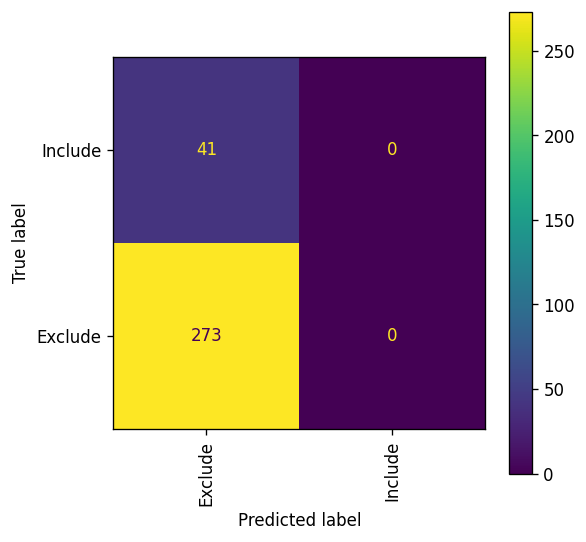

In [27]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
#ax.set_title(col)
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred.argmax(axis=1),
    labels=list(range(len(lnames))),
    display_labels=lnames,
    xticks_rotation='vertical',
    ax=ax
)
ax.invert_yaxis()
fig.show()

/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


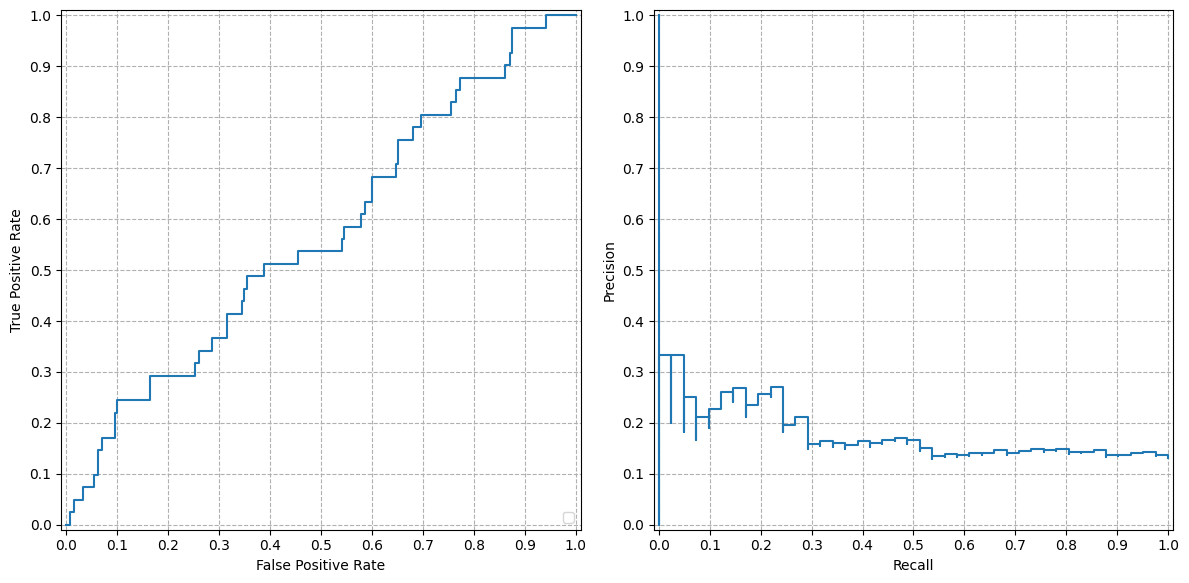

In [28]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, precision_recall_curve, PrecisionRecallDisplay

y_true = df[df['test']==1]['incl'].to_numpy().astype(int)
y_scores = df[df['test']==1]['pred_incl|1'].to_numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.grid(visible=True, linestyle='--')
ax2.set_xticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.grid(visible=True, linestyle='--')
fig.tight_layout()
plt.show()

(0.0, 1.0)

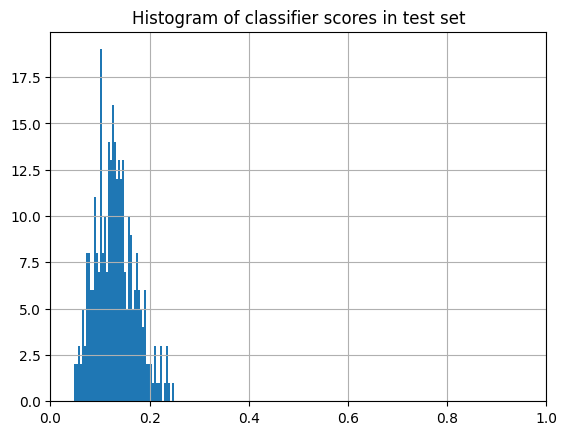

In [30]:
ax = df[df['test']==1]['pred_incl|1'].hist(bins=50)
ax.set_title('Histogram of classifier scores in test set')
ax.set_xlim(0, 1)

### Workload estimation
We'd like to know how much we ne need to annotate. Here, we compute rough estimations based on results from the latest classifier.

In [31]:
pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thresholds.tolist()+[1]}).T

0         1         2         3         4         5    \
precision  0.130573  0.130990  0.131410  0.131833  0.132258  0.132686   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.047806  0.049879  0.054136  0.055379  0.057369  0.058625   

                6         7         8         9         10        11   \
precision  0.133117  0.133550  0.133987  0.134426  0.134868  0.135314   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.059793  0.062306  0.063841  0.065045  0.065363  0.065947   

                12        13        14        15        16        17   \
precision  0.135762  0.136213  0.136667  0.137124  0.137584  0.134680   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  0.975610   
threshold  0.066272  0.067716  0.068162  0.071645  0.071799  0.072126   

                18        19        20        21        22        23   \
precision  0.135135  0.135593  0.136054  0.136519  0.136986  0.137457   
recall     0.975610  0.975610  0.975610  0.975610  0.975610  0.975610   
threshold  0.072261  0.072339  0.072802  0.074649  0.075328  0.075446   

                24        25        26        27        28        29   \
precision  0.137931  0.138408  0.138889  0.139373  0.139860  0.140351   
recall     0.975610  0.975610  0.975610  0.975610  0.975610  0.975610   
threshold  0.075728  0.076125  0.076679  0.076927  0.077681  0.078227   

                30        31        32        33        34        35   \
precision  0.140845  0.141343  0.141844  0.142349  0.142857  0.143369   
recall     0.975610  0.975610  0.975610  0.975610  0.975610  0.975610   
threshold  0.078513  0.079201  0.079828  0.080653  0.081649  0.081680   

                36        37        38        39        40        41   \
precision  0.140288  0.137184  0.137681  0.134545  0.135036  0.135531   
recall     0.951220  0.926829  0.926829  0.902439  0.902439  0.902439   
threshold  0.082051  0.082748  0.083589  0.084256  0.084570  0.084665   

                42        43        44        45        46        47   \
precision  0.136029  0.132841  0.133333  0.133829  0.134328  0.134831   
recall     0.902439  0.878049  0.878049  0.878049  0.878049  0.878049   
threshold  0.085677  0.086265  0.086965  0.089017  0.089545  0.089639   

                48        49        50        51        52        53   \
precision  0.135338  0.135849  0.136364  0.136882  0.137405  0.137931   
recall     0.878049  0.878049  0.878049  0.878049  0.878049  0.878049   
threshold  0.089880  0.089957  0.090078  0.091011  0.091197  0.091558   

                54        55        56        57        58        59   \
precision  0.138462  0.138996  0.139535  0.140078  0.140625  0.141176   
recall     0.878049  0.878049  0.878049  0.878049  0.878049  0.878049   
threshold  0.092020  0.092265  0.093277  0.093427  0.093446  0.094090   

                60        61        62        63        64        65   \
precision  0.141732  0.142292  0.142857  0.143426  0.144000  0.144578   
recall     0.878049  0.878049  0.878049  0.878049  0.878049  0.878049   
threshold  0.094461  0.094991  0.095335  0.095817  0.097123  0.097426   

                66        67        68        69        70        71   \
precision  0.145161  0.145749  0.142276  0.142857  0.143443  0.139918   
recall     0.878049  0.878049  0.853659  0.853659  0.853659  0.829268   
threshold  0.097605  0.098119  0.098268  0.099283  0.099711  0.100522   

                72        73        74        75        76        77   \
precision  0.140496  0.141079  0.141667  0.138075  0.138655  0.139241   
recall     0.829268  0.829268  0.829268  0.804878  0.804878  0.804878   
threshold  0.100599  0.100893  0.101020  0.101024  0.101133  0.101494   

                78        79        80        81        82        83   \
precision  0.139831  0.140426  0.141026  0.141631  0.142241  0.142857   
recall     0.804878  0.804878  0.804878  0.804878  0.804878  

In [34]:
for TARGET_RECALL in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98]:
    print('=================================')
    print(f'Stats for target recall of {TARGET_RECALL}')
    print('=================================')
    print('> Stats on test set')
    idx = np.argwhere(recall > TARGET_RECALL).max()
    print('idx', idx)
    print('num test items:', len(y_pred))
    print('threshold', thresholds[idx])
    print('precision', precision[idx])
    print('recall', recall[idx])
    print('num above threshold:', (y_pred >= thresholds[idx]).sum())
    print('num below threshold:', (y_pred < thresholds[idx]).sum())
    print('approx. false negative:', int(len(y_pred) * (1 - recall[idx])))
    print('approx. false positive:', int((y_pred >= thresholds[idx]).sum() * (1 - precision[idx])))
    print()
    
    print('> Extrapolation')
    
    mask_th = df['pred_incl|1'] > thresholds[idx]
    n_incl = mask_th.sum()
    r = recall[idx]
    p = precision[idx]

    print(f'Total documents: {df.shape[0]:,}')
    print(f'Num documents above threshold: {mask_th.sum():,}, num docs above threshold: {n_incl:,}')
    print(f'Extrapolating false negatives based on test recall: {int(mask_th.sum() * (1-r)):,}')
    print(f'Extrapolating false positives based on test precision: {int(n_incl * (1-p)):,}')

    print()

Stats for target recall of 0.7
> Stats on test set
idx 108
num test items: 314
threshold 0.11258324
precision 0.1407766990291262
recall 0.7073170731707317
num above threshold: 520
num below threshold: 108
approx. false negative: 91
approx. false positive: 446

> Extrapolation
Total documents: 74,867
Num documents above threshold: 56,782, num docs above threshold: 56,782
Extrapolating false negatives based on test recall: 16,619
Extrapolating false positives based on test precision: 48,788

Stats for target recall of 0.75
> Stats on test set
idx 105
num test items: 314
threshold 0.1119308
precision 0.14832535885167464
recall 0.7560975609756098
num above threshold: 523
num below threshold: 105
approx. false negative: 76
approx. false positive: 445

> Extrapolation
Total documents: 74,867
Num documents above threshold: 57,153, num docs above threshold: 57,153
Extrapolating false negatives based on test recall: 13,939
Extrapolating false positives based on test precision: 48,675

Stats for

## Assignment
This section of the notebook can be run independently of the previous sections as it loads data from the file we saved before (assuming to ran the imports from the very first cell).

### Data loading
Fetching which items were previously assigned from the database and load the predictions from the file.

**Adjust** the filename!

In [ ]:
with db_engine.session() as session:
    rslt = session.execute(select(distinct(Assignment.item_id))
                           .join(Item)
                           .where(Item.project_id == PROJECT_ID)).scalars().all()
    print(len(rslt))
assigned_item_ids = [str(r) for r in rslt]

In [ ]:
df = pd.read_feather(f'data/screening_round_04.arrow')
df['incl'] = df['incl'].astype('Int8')
df['py'] = df['py'].astype('Int16')
df = df.replace({np.nan: None})

### Assignment stats
We'd like to know how much data we still have to assign. The following cell computes that per category of queries. It also estimates how much data there's still to annotate (>0.5 threshold)

In [39]:
print('Sanity checks:')
mask_assigned = df['assigned'].astype(bool)
mask_seen = df['seen'].astype(bool)
mask_resolved = df['resolved'].astype(bool)
mask_rel = df['Classified relevant'].astype(bool)

print(f'Assigned: {mask_assigned.sum():,}, not assigned: {(~mask_assigned).sum():,}')
print(f'Seen: {mask_seen.sum():,}, not seen: {(~mask_seen).sum():,}')
print(f'Resolved: {mask_resolved.sum():,}, not resolved: {(~mask_resolved).sum():,}')

dfs = df[~mask_assigned].sort_values('pred_incl|0').head(n=100)

t1h = dfs.index.isin(df.index)
t2h = dfs.index.isin(df[~mask_assigned & mask_rel].index)
t3h = dfs.index.isin(df[mask_rel].index)
print(f'All: {df.shape[0]:,} (above 0.5 threshold: {(df['pred_incl|1']>0.5).sum()}, in top 100: {t1h.sum():,})')
print(f'"Relevant": {mask_rel.sum():,} (above 0.5 threshold: {((df['pred_incl|1']>0.5) & mask_rel).sum()}, in top 100: {t3h.sum():,})')
print(f'Unassgined: {(~mask_assigned).sum():,} (above 0.5 threshold: {((df['pred_incl|1']>0.5) & ~mask_assigned).sum()}, in top 100: {t2h.sum():,})')
print(f'Unassgined "relevant": {(~mask_assigned & mask_rel).sum():,} (above 0.5 threshold: {((df['pred_incl|1']>0.5) & ~mask_assigned & mask_rel).sum()}, in top 100: {t2h.sum():,})')


Sanity checks:
Assigned: 1,568, not assigned: 73,299
Seen: 1,568, not seen: 73,299
Resolved: 499, not resolved: 74,368
All: 74,867 (above 0.5 threshold: 0, in top 100: 100)
"Relevant": 9,131 (above 0.5 threshold: 0, in top 100: 4)
Unassgined: 73,299 (above 0.5 threshold: 0, in top 100: 4)
Unassgined "relevant": 8,000 (above 0.5 threshold: 0, in top 100: 4)


In [41]:
from matplotlib import pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3), dpi=120)

y = np.array(sorted(df['pred_incl|1'], reverse=True))
x = np.argwhere(y > 0.5).max()
ax1.plot(y)
ax1.vlines(x, 0, 1, colors='green', ls=':', lw=1)
ax1.set_title('All scores sorted')

y = np.array(sorted(df[mask_rel]['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax2.plot(y)
ax2.vlines(x,0,1, colors='green', ls=':', lw=1)
ax2.set_title('Scores for relative items sorted')

y = np.array(sorted(df[~mask_assigned & mask_rel]['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
ax3.plot(y)
ax3.vlines(x, 0, 1, colors='green', ls=':', lw=1)
ax3.set_title('Scores for relevant unassigned items sorted')

fig.tight_layout()

ValueError: zero-size array to reduction operation maximum which has no identity

### Create assignments
Here, we finally create the assignments (and a new assignment scope). This expects that you ran everything in the *Assignment* section of this notebook up to this point. Note, that the database connection might be stale after a long training cycle, so executing this cell might hang. In this case, restart the kernel and execute all *Assignment* cells again.

Note, that there's a security switch `DRY_RUN` in this cell. This prevents you from accidentally creating assignments. You should test this cell with `True` first. When everything looks as expected, run it with `False` and change it right back again.

**Adjust** `title`, `desc`, `LIMIT`, `users`, and if needed the inner loop logic.   
The convention for the title is `[date]_[method]_[query]_[annotators]`

In [51]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = True

LIMIT = 70
NUM_PER_ITEM = 2

users = [
    'diana.danilenko',
    'tarun.khanna'
]

# sorted relevant by relevance (highest inclusion first)
srtd = df[mask_rel & ~mask_assigned].sort_values('pred_incl|0')

with db_engine.session() as session:
    title = f'20240723_prioritised_DD'
    desc = f'Top {LIMIT} documents predicted to be relevant'

    scope_id = str(uuid.uuid4())
    print(f'Creating scope "{title}" with ID {scope_id}')
    if not DRY_RUN:
        scope = AssignmentScope(
            assignment_scope_id=scope_id,
            annotation_scheme_id=SCHEME_ID,
            name=title,
            description=desc
        )
        session.add(scope)
        session.flush()

    cnt = 0
    for di, (ri, row) in enumerate(srtd.head(LIMIT).iterrows()):
        item_id = row['item_id']
        
        if not DRY_RUN:
            df.loc[ri, 'assigned'] = True

        print(f'#{di + 1}/{LIMIT} | Creating assignments for {item_id}')

        for ui in range(NUM_PER_ITEM):  # Number of annotators per item
            username = users[(di + ui) % len(users)]
            user_id = USERS[username]
            assi_id = uuid.uuid4()
            
            if not DRY_RUN:
                assi = Assignment(assignment_id=assi_id,
                                  assignment_scope_id=scope_id,
                                  user_id=user_id,
                                  item_id=item_id,
                                  annotation_scheme_id=SCHEME_ID,
                                  status=AssignmentStatus.OPEN,
                                  order=di)
                session.add(assi)
                session.flush()
            cnt += 1
            print(f'  -> {username} via {assi_id} for scope {scope_id}')
    print(f'Created {cnt} assignments!')


Creating scope "20240723_prioritised_DD" with ID 61e65ef4-4e7c-4cfa-b2eb-b73d570f883a
#1/70 | Creating assignments for 6b642271-55c1-47dc-999d-c97f0dd5b223
  -> diana.danilenko via 1e82776a-3b7b-448e-9cf6-431b36b7eef3 for scope 61e65ef4-4e7c-4cfa-b2eb-b73d570f883a
  -> tarun.khanna via fedd074d-e569-4272-8189-432f0f9e0a16 for scope 61e65ef4-4e7c-4cfa-b2eb-b73d570f883a
#2/70 | Creating assignments for fadd9696-5cbb-4ccb-a6a1-b3ac6958a674
  -> tarun.khanna via 8a570d7c-2896-407f-81ea-6389b73cceb8 for scope 61e65ef4-4e7c-4cfa-b2eb-b73d570f883a
  -> diana.danilenko via 39901a43-97f6-4e2f-82c2-037ee4ede505 for scope 61e65ef4-4e7c-4cfa-b2eb-b73d570f883a
#3/70 | Creating assignments for 3cc7b67e-89b4-4282-b9ea-04d8d7042409
  -> diana.danilenko via 8300d16b-fb2d-4b14-a069-ffa68792382c for scope 61e65ef4-4e7c-4cfa-b2eb-b73d570f883a
  -> tarun.khanna via a29a3cf9-5a4e-41ed-ad47-644454db123f for scope 61e65ef4-4e7c-4cfa-b2eb-b73d570f883a
#4/70 | Creating assignments for 2b172fe1-bf5f-48f6-8462-83

In [ ]:
df['assigned'].sum()

### Storing assignments
We'd like to keep the assignments outside of the platform if we need it again. 

**Adjust** the filename by increasing the counter by 1.

In [ ]:
df.to_feather(f'data/screening_round_04_post.arrow')